# Data reduction for CAHA Observations - Spectra
Based on UCM pipelines by Jaime Zamorano and Nico Cardiel (UCM).

Adapted by Maria Montguió, Hugo Traning and Nadejda Blagorodnova (UB).

### Preliminary steps 
 * Download your data (science and calibations) and set the path DATADIR to this dicretory.
 * Download the files 'tea_utils.py' and 'tea_wavecal.py'
 * install ccdproc ("conda install -c astropy ccdproc")
 

In [4]:
#Define directory where your data are
DATADIR='/Users/nadiablago/Documents/Observing/Data/231222_CAFOS'

In [11]:
# IMPORTS:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from ccdproc import ImageFileCollection #conda install -c astropy ccdproc
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
#from tea_utils import tea_avoid_astropy_warnings
from tea_utils import tea_imshow
from tea_utils import tea_ifc_statsummary
from tea_utils import SliceRegion2D
import numpy as np
import matplotlib.patches as patches
from astropy.nddata import CCDData
import ccdproc
from astropy.stats import mad_std
from tea_utils import tea_statsummary
from tqdm.notebook import tqdm
from astropy.nddata.nduncertainty import StdDevUncertainty
from ccdproc import ImageFileCollection
from tea_utils import tea_avoid_astropy_warnings
from tea_wavecal import TeaWaveCalibration
from tea_utils import SliceRegion1D
import astropy.units as u
from tea_wavecal import apply_wavecal_ccddata
from tea_wavecal import fit_sdistortion
from tea_wavecal import polfit_residuals_with_sigma_rejection
import os, glob

tea_avoid_astropy_warnings(True)

### Visualize the content of your directory.

The selected keywords contain the most relevant keywords of interest in the metadata headers of your fits files. The code will list this keywords for all the files in your DATADIR.
The most relevant are:
* IMAGETYP: The type of content in your fits. bias, arc, flat, science.
* OBJECT: says the name of the data is contained in the fits file. E.g. the configuration for the calibrations or the name of your target.
* INSAPDY: Slit width in microns.
* INSGRID: Grism used. For example, GRISM-9 corresponds to G200.
* INSGRNAM: Name of the grism.
* INSGRROT: Angle rotation of the grism.
* EXPTIME: exposure time of this image.
* NAXIS1: Number of pixes in the X direction. Should be 1400 for spectral images.
* NAXIS2: Number of pixels in the Y direction. Should be 2048 for spectral images.

In [12]:
#CHECK IMAGES AVAILABLE
selected_keywords = [ #fits header parameters to check
    'IMAGETYP', 'NAXIS1', 'NAXIS2', 'OBJECT' , 
        'INSAPDY', 'INSGRID', 'INSGRNAM', 'INSGRROT', 'EXPTIME' , 'INSFLID', 'DATE-OBS'
]

directory=Path(DATADIR)
ifc_all = ImageFileCollection(
    location=directory,
    glob_include='caf*.fits',
    keywords=selected_keywords
)

summary_all = tea_ifc_statsummary(ifc_all, directory)
summary_all.show_in_notebook(display_length=25)

  0%|          | 0/32 [00:00<?, ?it/s]

idx,file,IMAGETYP,NAXIS1,NAXIS2,OBJECT,INSAPDY,INSGRID,INSGRNAM,INSGRROT,EXPTIME,INSFLID,DATE-OBS,npoints,minimum,maximum,mean,median,std,robust_std,percentile16,percentile25,percentile75,percentile84
0,caf-20231222-13:06:26-cal-blan.fits,arc,1400,2048,"[arc] HgHeRb 1.5""",129.0,GRISM- 9,green-200,239.69,1.0,FILT-12,2023-12-22T13:06:26,2867200,0.000,65535.000,976.897,701.000,2792.056,45.961,668.000,675.000,737.000,763.000
1,caf-20231222-13:07:53-cal-blan.fits,arc,1400,2048,"[arc] HgHeRb 1.5""",129.0,GRISM- 9,green-200,239.69,1.0,FILT-12,2023-12-22T13:07:53,2867200,0.000,65535.000,1109.230,708.000,3385.167,66.717,673.000,680.000,770.000,812.000
2,caf-20231222-13:09:21-cal-blan.fits,arc,1400,2048,"[arc] HgHeRb 1.5""",129.0,GRISM- 9,green-200,239.69,1.0,FILT-12,2023-12-22T13:09:21,2867200,0.000,65535.000,1148.850,709.000,3600.388,68.941,673.000,680.000,773.000,822.000
3,caf-20231222-13:11:30-cal-blan.fits,arc,1400,2048,"[arc] HgHeRb 1""",85.0,GRISM- 9,green-200,239.69,1.0,FILT-12,2023-12-22T13:11:30,2867200,0.000,65535.000,1048.409,697.000,3221.358,52.632,668.000,674.000,745.000,784.000
4,caf-20231222-13:12:57-cal-blan.fits,arc,1400,2048,"[arc] HgHeRb 1""",85.0,GRISM- 9,green-200,239.69,1.0,FILT-12,2023-12-22T13:12:57,2867200,0.000,65535.000,1067.134,698.000,3358.572,54.115,669.000,675.000,748.000,790.000
5,caf-20231222-13:14:24-cal-blan.fits,arc,1400,2048,"[arc] HgHeRb 1""",85.0,GRISM- 9,green-200,239.69,1.0,FILT-12,2023-12-22T13:14:24,2867200,0.000,65535.000,1081.310,701.000,3450.957,57.080,670.000,675.000,752.000,796.000
6,caf-20231222-13:34:30-cal-blan.fits,flat,1400,2048,"[flat] Dome G200 1""",85.0,GRISM- 9,green-200,239.69,4.0,FILT-12,2023-12-22T13:34:30,2867200,0.000,65505.000,7073.025,3893.000,6881.710,8956.387,854.000,995.000,13077.000,16397.000
7,caf-20231222-13:36:14-cal-blan.fits,flat,1400,2048,"[flat] Dome G200 1""",85.0,GRISM- 9,green-200,239.69,4.0,FILT-12,2023-12-22T13:36:14,2867200,0.000,65482.000,7069.780,3868.000,6883.559,8986.039,853.000,993.000,13115.000,16393.000
8,caf-20231222-13:37:43-cal-blan.fits,flat,1400,2048,"[flat] Dome G200 1""",85.0,GRISM- 9,green-200,239.69,4.0,FILT-12,2023-12-22T13:37:43,2867200,0.000,65510.000,7091.642,3875.000,6906.712,9026.069,854.000,994.000,13170.000,16446.000
9,caf-20231222-13:39:14-cal-blan.fits,flat,1400,2048,"[flat] Dome G200 1""",85.0,GRISM- 9,green-200,239.69,4.0,FILT-12,2023-12-22T13:39:14,2867200,0.000,65485.000,7111.869,3883.000,6927.772,9060.169,854.000,995.000,13217.000,16494.682


## Plot all the images for visual inspection.
This step creates a new directory called "plots" within the data directory, and plots all the fits images there for visual inspection.

In [16]:
#The plots directory is created inside the DATADIR.

PLOTDIR=os.path.join(DATADIR, "plots")

if not os.path.isdir(PLOTDIR):
    os.makedirs(PLOTDIR)
    
#Show a few images:
for example_image in glob.glob(os.path.join(DATADIR,"caf*fits")):
    image_name = os.path.basename(example_image).split(".")[0]
    data = fits.getdata(example_image)
    header = fits.getheader(example_image)
    vmin, vmax = np.percentile(data, [40, 99]) #Play woth these values to avoid saturation of the image.
    fig, ax = plt.subplots(figsize=(25, 15))
    tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax)
    ax.set_title('{1} ({0})'.format( os.path.basename(example_image),header['OBJECT']))
    plt.savefig(os.path.join(PLOTDIR, image_name+".png"), dpi=80)
    plt.close()


# Checking BIAS

We make a selection of all the bias fits files to combine them later.

In [18]:
#BIAS IMAGES
summary_all = tea_ifc_statsummary(ifc_all, directory)
summary_all.show_in_notebook(display_length=50)
matches_bias= ['bias' in object_name.lower() for object_name in ifc_all.summary['OBJECT']]
summary_bias = summary_all[matches_bias]
summary_bias

  0%|          | 0/32 [00:00<?, ?it/s]

file,IMAGETYP,NAXIS1,NAXIS2,OBJECT,INSAPDY,INSGRID,INSGRNAM,INSGRROT,EXPTIME,INSFLID,DATE-OBS,npoints,minimum,maximum,mean,median,std,robust_std,percentile16,percentile25,percentile75,percentile84
str35,str7,int64,int64,str21,float64,str8,str9,float64,float64,str7,str19,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
caf-20231222-14:06:09-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:06:09,2867200,0.000,18186.000,660.668,657.000,204.367,7.413,650.000,652.000,662.000,664.000
caf-20231222-14:07:35-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:07:35,2867200,0.000,17131.000,659.580,656.000,202.096,6.672,649.000,651.000,660.000,663.000
caf-20231222-14:09:02-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:09:02,2867200,0.000,15845.000,660.678,657.000,202.471,7.413,650.000,652.000,662.000,664.000
caf-20231222-14:10:28-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:10:28,2867200,0.000,16699.000,659.566,656.000,202.713,6.672,649.000,651.000,660.000,663.000
caf-20231222-14:11:55-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:11:55,2867200,0.000,17894.000,660.718,657.000,202.852,7.413,650.000,652.000,662.000,664.000
caf-20231222-14:13:22-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:13:22,2867200,0.000,18968.000,659.692,656.000,202.497,6.672,649.000,651.000,660.000,663.000
caf-20231222-14:14:49-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:14:49,2867200,0.000,12471.000,660.721,657.000,202.224,7.413,650.000,652.000,662.000,664.000
caf-20231222-14:16:15-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:16:15,2867200,0.000,15677.000,659.738,656.000,202.477,7.413,649.000,651.000,661.000,663.000
caf-20231222-14:17:42-cal-blan.fits,bias,1400,2048,[bias],129.0,GRISM- 9,green-200,239.69,0.0,FILT-12,2023-12-22T14:17:42,2867200,0.000,20508.000,660.806,657.000,203.804,7.413,650.000,652.000,662.000,664.000


In [19]:
#Visual inspection of the bias:
'''for filename, dateobs in summary_bias['file', 'DATE-OBS']:
    data = fits.getdata(directory / filename)
    fig, ax = plt.subplots(figsize=(15, 5))
    vmin, vmax = np.percentile(data, [5, 95])
    tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax)
    ax.set_title(f'{filename}, {dateobs}')
    plt.show()'''

"for filename, dateobs in summary_bias['file', 'DATE-OBS']:\n    data = fits.getdata(directory / filename)\n    fig, ax = plt.subplots(figsize=(15, 5))\n    vmin, vmax = np.percentile(data, [5, 95])\n    tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax)\n    ax.set_title(f'{filename}, {dateobs}')\n    plt.show()"

## Check the overscan regions.
This code plots the edge of the detector.

In [25]:
#Funcion to plot and check overscan regions
def plot_bias_frames(
    region_underscan,
    region_overscan,
    subtract_underoverscan=False
):
    fig = plt.figure(figsize=(15, 15))
    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 2, 3)
    ax3 = plt.subplot(2, 2, 4)

    ymin, ymax = 655,660#682, 697

    for filename, dateobs in summary_bias['file', 'DATE-OBS']:
        data = fits.getdata(directory / filename)
        if subtract_underoverscan:
            # regions are given following FITS convention
            med_underscan = np.median(data[region_underscan.python])
            med_overscan = np.median(data[region_overscan.python])
            print(f'{filename}: underscan: {med_underscan}, overscan: {med_overscan}')
            med_underoverscan = (med_underscan + med_overscan) / 2
            data = data - med_underoverscan
            ymin_ = ymin - med_underoverscan
            ymax_ = ymax - med_underoverscan
        else:
            ymin_ = ymin
            ymax_ = ymax
        naxis2, naxis1 = data.shape
        xplot = np.arange(naxis1)
        for ax in [ax1, ax2, ax3]:
            ax.plot(xplot, np.median(data, axis=0), lw=1, label=filename)
        ax1.set_title(f'{filename}, {dateobs}')

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim([ymin_, ymax_])
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')

    x1_underscan = region_underscan.python[1].start
    x2_underscan = region_underscan.python[1].stop
    ax2.set_xlim([x1_underscan - 5, x2_underscan + 50])
    
    x1_overscan = region_overscan.python[1].start
    x2_overscan = region_overscan.python[1].stop
    ax3.set_xlim([x1_overscan - 50, x2_overscan + 5])

    rect_underscan = patches.Rectangle(
        xy=(x1_underscan, ymin_), 
        width=x2_underscan - x1_underscan, 
        height=ymax_ - ymin_, 
        color='C0', alpha=0.2
    )
    rect_overscan = patches.Rectangle(
        xy=(x1_overscan, ymin_), 
        width=x2_overscan - x1_overscan, 
        height=ymax_-ymin_, 
        color='C0', alpha=0.2
    )

    ax2.add_patch(rect_underscan)
    ax3.add_patch(rect_overscan)

    ax1.legend(ncol=5);

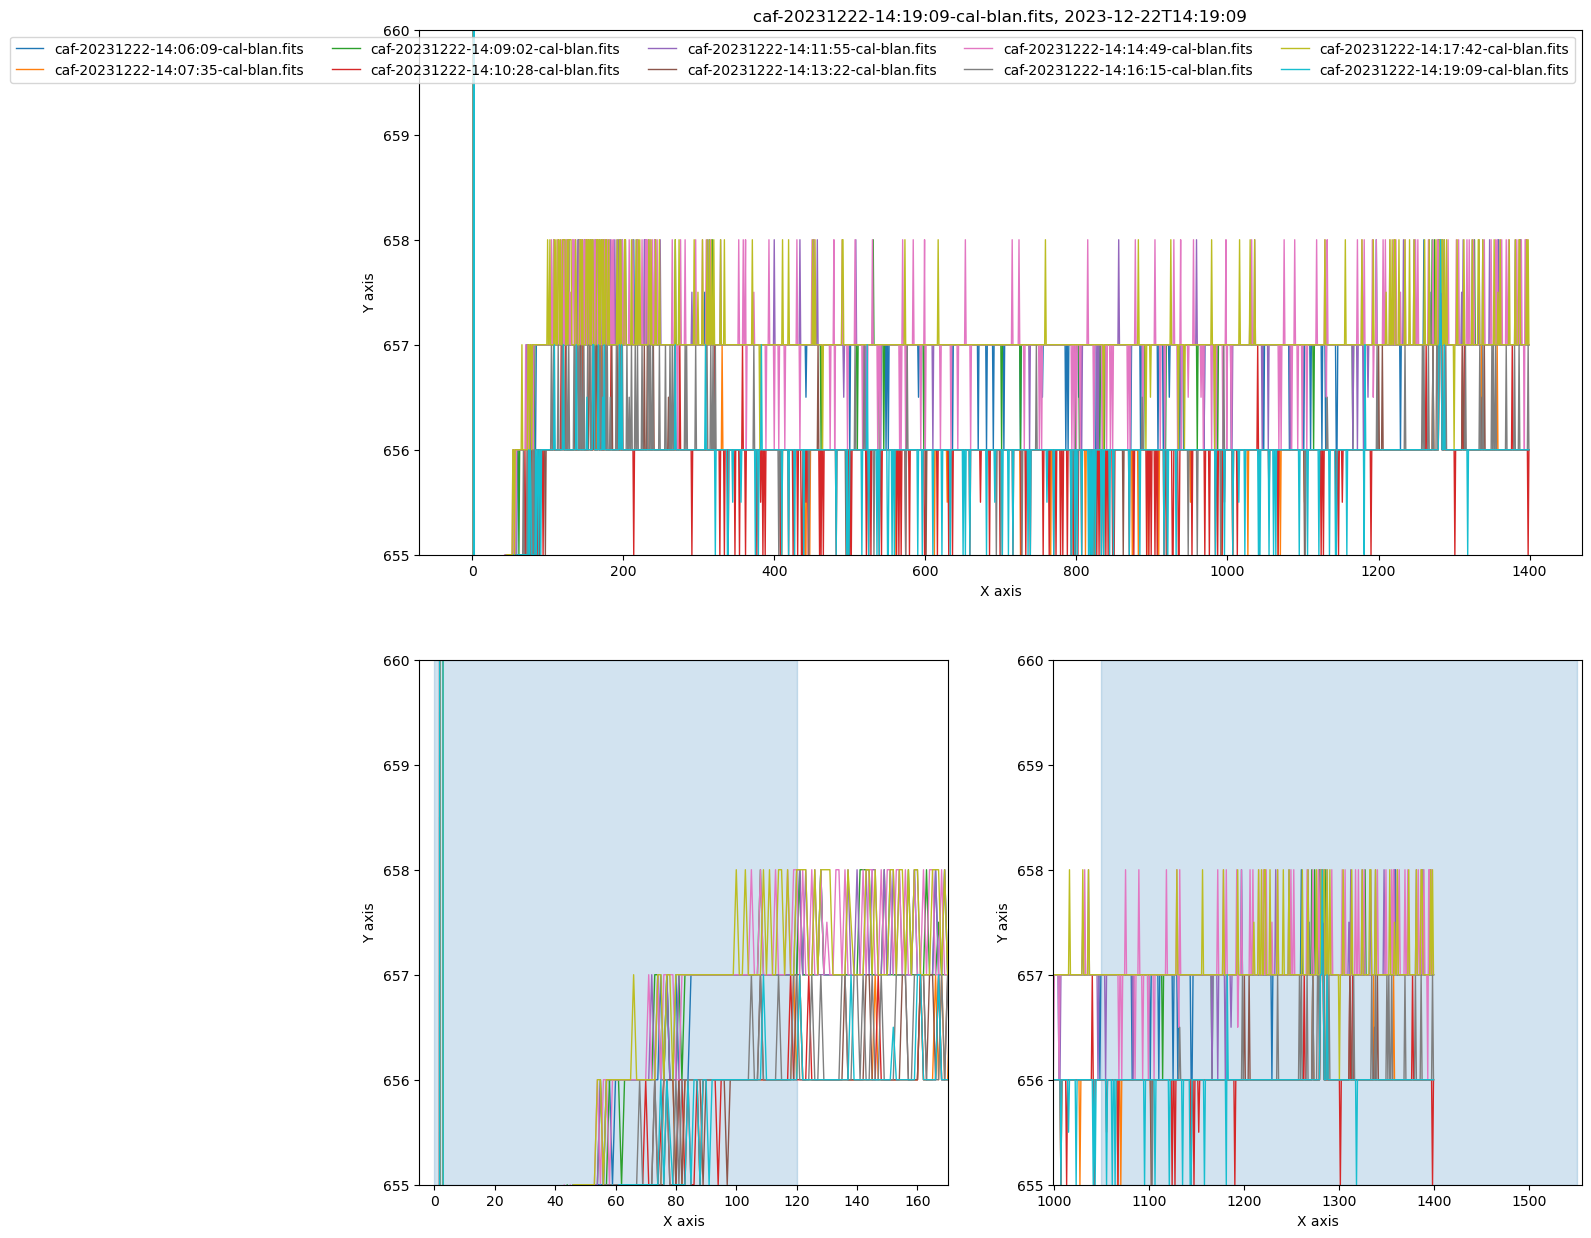

In [26]:
plot_bias_frames(
    region_underscan=SliceRegion2D(np.s_[1:120, 1:2000], mode='fits'),
    region_overscan=SliceRegion2D(np.s_[1050:1550, 1:2000], mode='fits'),
    subtract_underoverscan=False
)

In [27]:
# underscan region (FITS convention)
region_underscan = SliceRegion2D(np.s_[1:120, 1:250], mode='fits')
# overscan region (FITS convention)
region_overscan = SliceRegion2D(np.s_[1050:1550, 1:250], mode='fits')
# useful region (FITS convention)
region_useful = SliceRegion2D(np.s_[130:1000, 200:2000], mode='fits')


   * We define the different overscan and useful regions. 
   * Carefull, there is a different convention between fits and python.
   * SliceRegion2D helps you with that

# Generate masterbias

Combine the bias to create a masterbias.

In [ ]:
list_bias = []
for filename in summary_bias['file']:
    filepath = directory / filename

    print(f'Reading {filepath}')
    data = fits.getdata(filepath)
    header = fits.getheader(filepath)
    
    # compute and subtract median from underscan & overscan regions
    """
    med_underscan = np.median(data[region_underscan.python])
    med_overscan = np.median(data[region_overscan.python])
    med_underoverscan = (med_underscan + med_overscan) / 2
    data = data - med_underoverscan
    """
    # create CCDData instance and append to list
    list_bias.append(CCDData(data=data, header=header, unit='adu'))
    
num_bias = len(list_bias)
print(f'Number of BIAS exposures: {num_bias}')

master_bias = ccdproc.combine(
    img_list=list_bias,
    method='average',
    sigma_clip=True, sigma_clip_low_thres=5, sigma_clip_high_thresh=5,
    sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std
)

In [ ]:
#Write info and save master_bias
#There are two parameters weird, better remove them
list_keywords_to_be_removed = ['CCDXPIXE', 'CCDYPIXE']
for keyword in list_keywords_to_be_removed:
    if keyword in master_bias.header:
        del master_bias.header[keyword]
        
num_bias = len(list_bias)

# Insert FILENAME keyword and include additional information
filename_master_bias = 'master_bias.fits'
master_bias.header['FILENAME'] = filename_master_bias
master_bias.header['HISTORY'] = '-------------------'
master_bias.header['HISTORY'] = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
master_bias.header['HISTORY'] = f'master BIAS combining {num_bias} BIAS images'
#master_bias.header['HISTORY'] = 'after subtracting median from under/overscan regions'
#master_bias.header['HISTORY'] = f'underscan (FITS): {region_underscan.fits}'
#master_bias.header['HISTORY'] = f'overscan  (FITS): {region_overscan.fits}'
master_bias.header['HISTORY'] = 'using ccdproc.combine, with average and sigma clipping'
for filename in summary_bias['file']:
    master_bias.header['HISTORY'] = f"+ {filename}"

#Now I trim because biases are different shape. You don't need to!
#region_useful = SliceRegion2D(np.s_[1:1100, 1:1600], mode='fits')
#fits_section = region_useful.fits_section
#master_bias = ccdproc.trim_image(master_bias, fits_section=fits_section)

# save result
master_bias.write(directory / filename_master_bias, overwrite='yes')      
median_bias = np.median(master_bias.data)
gain = master_bias.header['CCDSENS']
readout_noise = np.mean(summary_bias['robust_std'])

In [ ]:
#Chack that the resulting master_bias.
_ = tea_statsummary(master_bias.data)
fig, ax = plt.subplots(figsize=(15, 5))
vmin, vmax = np.percentile(data, [5, 95])
tea_imshow(fig, ax, master_bias, vmin=vmin, vmax=vmax)
ax.set_title('Master BIAS')

In [ ]:
#We apply the masterbias to all other images

no_bias= summary_all['IMAGETYP'] != 'bias'
summary_nobias = summary_all[no_bias]

for filename in tqdm(summary_nobias['file']):
    filepath = directory / filename
    
    
    # read data and header from file
    data = fits.getdata(filepath)
    header = fits.getheader(filepath)
    print(filepath,header['OBJECT'])
    
    # remove non-standard keywords from header
    list_keywords_to_be_removed = ['CCDXPIXE', 'CCDYPIXE']
    for keyword in list_keywords_to_be_removed:
        if keyword in header:
            del header[keyword]
    
    # compute and subtract median from underscan & overscan regions
    """
    med_underscan = np.median(data[region_underscan.python])
    med_overscan = np.median(data[region_overscan.python])
    med_underoverscan = (med_underscan + med_overscan) / 2
    data = data - med_underoverscan
    """
    # create associated uncertainty
    uncertainty1 = (data - median_bias) / gain
    uncertainty1[uncertainty1 < 0] = 0.0   # remove unrealistic negative estimates
    uncertainty2 = readout_noise**2
    uncertainty = np.sqrt(uncertainty1 + uncertainty2)
    
    # create CCDData instance
    ccdimage = CCDData(
        data=data, 
        header=header,
        uncertainty=StdDevUncertainty(uncertainty),
        unit='adu'
    )
    

    
    # subtract master_bias
    ccdimage_bias_subtracted = ccdproc.subtract_bias(ccdimage, master_bias)
    
    
    # rotate primary HDU and extensions
    ccdimage_bias_subtracted.data = np.rot90(ccdimage_bias_subtracted.data, 3)
    ccdimage_bias_subtracted.mask = np.rot90(ccdimage_bias_subtracted.mask, 3)
    ccdimage_bias_subtracted.uncertainty.array = np.rot90(ccdimage_bias_subtracted.uncertainty.array, 3)

    # update HISTORY in header
    ccdimage_bias_subtracted.header['HISTORY'] = '-------------------'
    ccdimage_bias_subtracted.header['HISTORY'] = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    ccdimage_bias_subtracted.header['HISTORY'] = 'rotating image using np.rot90(array, 3)'

    
    # update FILENAME keyword with output file name
    output_filename = f'z_{filename}'
    ccdimage_bias_subtracted.header['FILENAME'] = output_filename
    # update HISTORY in header
    ccdimage_bias_subtracted.header['HISTORY'] = '-------------------'
    ccdimage_bias_subtracted.header['HISTORY'] = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    ccdimage_bias_subtracted.header['HISTORY'] = 'using ccdproc.subtract_bias'
    ccdimage_bias_subtracted.header['HISTORY'] = f'master BIAS file: {filename_master_bias}'
    
    # save result
    ccdimage_bias_subtracted.write(directory / output_filename, overwrite='yes')

# Dark correction
Gnerally not needed for optical data.

In [ ]:
#List of files bias corrected:
selected_keywords = [
    'NAXIS1', 'NAXIS2', 
    'OBJECT' , 'IMAGETYP', 'EXPTIME' , 'DATE-OBS', 'UTSTART' , 
    'CCDSTEMP', 'CCDATEMP',
    'GRATNAME', 'GRATRULE', 'GRATANGL'
]

ifc_all = ImageFileCollection(
    location=directory,
    glob_include='z_*.fits',
    keywords=selected_keywords
)

print(f'Total number of files: {len(ifc_all.summary)}')

#List of darks:


matches_dark = summary_all['IMAGETYP'] == 'dark'
summary_dark = summary_all[matches_dark]
summary_dark.show_in_notebook(display_length=10)


No darks available

We do not apply dark correction for now

# Flat field 

In [ ]:
#We create a list of flats.

selected_keywords = ['IMAGETYP', 'NAXIS1', 'NAXIS2', 'OBJECT' , 
        'INSAPDY', 'INSGRID', 'INSGRROT', 'EXPTIME' , 'INSFLID', 'DATE-OBS'
]

ifc_all = ImageFileCollection(
    location=directory,
    glob_include='z_*.fits',
    keywords=selected_keywords
)

summary_all = tea_ifc_statsummary(ifc_all, directory)

matches_flat = ['flat' in object_name.lower() for object_name in summary_all['OBJECT']]
summary_flat = summary_all[matches_flat]
summary_flat.show_in_notebook(display_length=10)

Check if you have different combinations of INSGRID and INSROT. You need a flat for each combination.


In [ ]:
#Check each of the flats
for filename, objname, exptime, median, robust_std in summary_flat[
    'file', 'OBJECT', 'EXPTIME', 'median', 'robust_std'
]:
    data = fits.getdata(directory / filename)
    vmin = median - 2 * robust_std
    vmax = median + 2 * robust_std
    vmin, vmax = np.percentile(data, [2, 99.9])
    fig, ax = plt.subplots(figsize=(15, 5))
    tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax)
    ax.set_title(f'{filename}  [{objname}]  EXPTIME={exptime} s')
    plt.show()

In [ ]:
#We use only the lamp flats or sky flats - Dome g200 flat
'''
matches_flat = (summary_all['INSGRID'] == 'GRISM- 9')*(summary_all['IMAGETYP'] == 'flat')
summary_flat = summary_all[matches_flat]
summary_flat
'''

In [ ]:
# list of CCDData instances (normalized images)
list_flats = []
for filename in tqdm(summary_flat['file']):
    filepath = directory / filename
    
    # CCDData instance from file
    ccdimage = CCDData.read(filepath)
    
    # normalize image dividing by the median spectrum
    ccdimage = ccdimage.divide(np.median(ccdimage.data, axis=0), handle_meta='first_found')
    
    # append to list
    list_flats.append(ccdimage)
    
num_flats = len(list_flats)
print(f'Number of FLATS exposures: {num_flats}')

# combine images
print(f'Combining {num_flats} images')
for ccdimage in list_flats:
    print(f"- Normalized {ccdimage.header['FILENAME']}")

master_flat = ccdproc.combine(
    img_list=list_flats,
    method='average',
    sigma_clip=True, sigma_clip_low_thres=5, sigma_clip_high_thres=5,
    sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std
)

# update header keywords
output_filename = f'N1_master_flat.fits'
master_flat.header['FILENAME'] = output_filename
master_flat.header['HISTORY'] = '-------------------'
master_flat.header['HISTORY'] = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
master_flat.header['HISTORY'] = f'master FLAT combining {num_flats} FLAT images'
master_flat.header['HISTORY'] = 'using ccdproc.combine, with average and sigma clipping'
for ccdimage in list_flats:
    master_flat.header['HISTORY'] = f"+ {ccdimage.header['FILENAME']}"

print(f'Saving {output_filename}')

# save result
master_flat.write(directory / output_filename, overwrite='yes')

# display combined image
naxis2, naxis1 = master_flat.data.shape

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
vmin, vmax = 0.85, 1.15
vmin, vmax = np.percentile(master_flat.data, [5, 99])
tea_imshow(fig, ax1, master_flat.data, vmin=vmin, vmax=vmax)


#  Correcting all images using the master flat

In [ ]:
matches_no_flat = summary_all['IMAGETYP'] != 'FLAT'
matches_no_flat = matches_no_flat & (summary_all['IMAGETYP'] != 'SKY')
matches_no_flat = matches_no_flat & (summary_all['IMAGETYP'] != 'BIAS')
matches_no_flat = matches_no_flat & (summary_all['IMAGETYP'] != 'DARK')
summary_no_flat = summary_all[matches_no_flat]
summary_no_flat.show_in_notebook(display_length=10)

In [ ]:
filename_master_flat = 'N1_master_flat.fits'
master_flat = CCDData.read(directory / filename_master_flat)

for i, filename in enumerate(tqdm(summary_no_flat['file'])):
    print(f'Flatfielding image: {filename}  --> File {i+1} / {len(summary_no_flat)}')
    
    # generate CCDData instance
    ccdimage = CCDData.read(directory / filename)

    # divide science exposure by master flat
    ccdimage_after_flat = ccdproc.flat_correct(ccdimage, master_flat)
    
    # update FILENAME keyword with output file name
    output_filename = f'f{filename}'
    ccdimage_after_flat.header['FILENAME'] = output_filename
    
    # update HISTORY in header
    ccdimage_after_flat.header['HISTORY']  = '-------------------'
    ccdimage_after_flat.header['HISTORY']  = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    ccdimage_after_flat.header['HISTORY'] = 'using ccdproc.flat_correct'
    ccdimage_after_flat.header['HISTORY'] = f'master Flat Field file: {filename_master_flat}'
    
    # save result
    ccdimage_after_flat.write(directory / output_filename, overwrite='yes')
    print(f'Output file name.: {output_filename}')
    
    # display image before and after flatfielding
    mean, median, std = sigma_clipped_stats(ccdimage_after_flat.data, sigma=3.0)
    vmin = median - 2 * std
    vmax = median + 2 * std
    vmin, vmax = np.percentile(ccdimage_after_flat.data, [5, 99.])
    fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    title = f"{filename}\n{ccdimage.header['OBJECT']}"
    tea_imshow(fig, axarr[0], ccdimage.data, vmin=vmin, vmax=vmax, title=title)
    title = f"{output_filename}\n{ccdimage.header['OBJECT']}"
    tea_imshow(fig, axarr[1], ccdimage_after_flat.data, vmin=vmin, vmax=vmax, title=title)

    plt.tight_layout()
    plt.show()

 We skip cosmic ray correction

# Wavelength calibration

In [ ]:
# Arc images
selected_keywords = [
    'IMAGETYP', 'NAXIS1', 'NAXIS2', 'OBJECT' , 
        'INSAPDY', 'INSGRID', 'INSGRROT', 'EXPTIME' , 'INSFLID', 'DATE-OBS'
]

ifc_all = ImageFileCollection(
    location=directory ,
    glob_include='fz_*.fits',
    keywords=selected_keywords
)
summary_all = ifc_all.summary

print(f'Total number of files N1...: {len(summary_all)}')

matches_arc = summary_all['IMAGETYP'] == 'arc'
summary_arc = summary_all[matches_arc]
summary_arc.show_in_notebook(display_length=None)



In [ ]:
for filename, objname in summary_arc['file', 'OBJECT']:
    data = fits.getdata(directory / filename)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    vmin = median - 2 * std
    vmax = median + 8 * std
    fig, ax = plt.subplots(figsize=(15, 5))
    tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax, 
               title=f'{filename}, {objname}')
    plt.show()

In [ ]:
#I choose one. Ideally you'd need one at each position. And with CUNEAr
arc_file='fz_caf-20240201-07_10_59-cal-blan.fits'
input_filename = directory / arc_file
data = fits.getdata(input_filename)

In [ ]:
#we use a slice between 120-130 to find the peaks
wavecalib = TeaWaveCalibration()
ns_range = SliceRegion1D(np.s_[600:700], mode='fits')
"""
xpeaks_reference, ixpeaks_reference, spectrum_reference = wavecalib.compute_xpeaks_reference(
    data=data,
    ns_range=ns_range,
    threshold=50,
    sigma_smooth=2,
    plot_spectrum=True,
    plot_peaks=True,
    title=input_filename.name
)
"""

In [ ]:
#Position of the peaks
xpeaks_reference

In [ ]:
xpeaks_reference_initial, ixpeaks_reference, spectrum_reference = wavecalib.compute_xpeaks_reference(
    data=data,
    sigma_smooth=1,
    delta_flux=10,
    ns_range=ns_range,
    plot_spectrum=True,
    plot_peaks=True
)

In [ ]:
for i, item in enumerate(xpeaks_reference_initial):
   print(f'{item:7.2f},#{i+1:2d}')

# Check http://w3.caha.es/CAHA/Instruments/CAFOS/comp.html to find reference lines

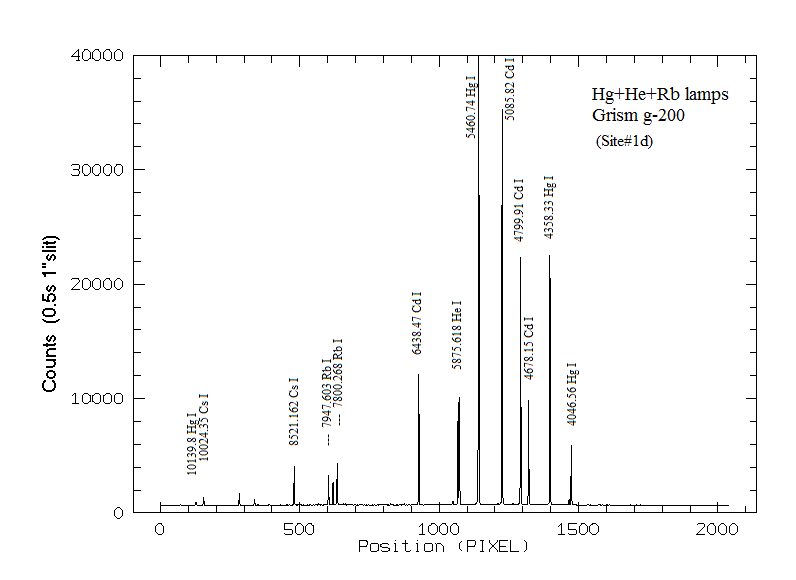

### Now improved with automatic search to have a first guess

In [ ]:
# reference lines and pixels for Hg+He+Rb lamps, grism g-200
comparison_reference_wav = np.array([4046.56, 4358.33, 4678.15, 4799.91, 5085.82, 5460.74,
                                     6438.47, 7800.268, 7947.603, 8521.162, 10139.8])
comparison_reference_pix = np.array([1475,1400,1320,1295,1225,1140,925,635,605,485,125])

# revert x-axis
comparison_reference_pix = 2000-comparison_reference_pix

In [ ]:
def find_best_match(observed_peaks, reference_peaks):
    max_matches = 0
    id_matches = []
    
    # Iterate over a range of potential differences
    for difference in np.arange(np.min(reference_peaks)-np.mean(observed_peaks),
                                np.max(reference_peaks)-np.mean(observed_peaks)):  
        id_matches_obs, id_matches_ref = find_peak_matches(observed_peaks, reference_peaks, difference)
        num_matches = len(id_matches_obs)
        if num_matches > max_matches:
            # Found a new best match
            max_matches = num_matches
            id_matches = (id_matches_obs, id_matches_ref)
    
    return id_matches

def find_peak_matches(observed_peaks, reference_peaks, difference, tol=10):
    reference_peaks_shifted = [peak - difference for peak in reference_peaks]
    
    # Find the matches between observed and shifted reference peaks within (tol) pix
    id_matches_obs = [np.argmin(np.abs(observed_peaks-reference_peaks_shifted[p])) for p in range(len(reference_peaks_shifted)) if np.min(np.abs(observed_peaks-reference_peaks_shifted[p]))<tol]
    id_matches_ref = [p for p in range(len(reference_peaks_shifted)) if np.min(np.abs(observed_peaks-reference_peaks_shifted[p]))<tol]
    
    return id_matches_obs, id_matches_ref

# Find the best match
observed_peaks = xpeaks_reference_initial.data.tolist()
reference_peaks = comparison_reference_pix
id_matches_obs, id_matches_ref = find_best_match(observed_peaks, reference_peaks)
id_matches_obs, id_matches_ref = np.array(id_matches_obs), np.array(id_matches_ref)

print("Number of matches:", len(id_matches_obs))
print("Indexes of matches:", id_matches_obs+1)
print("Corresponding wavelengths:", comparison_reference_wav[id_matches_ref])


# Apply peak wavelength assignment
xpeaks_reference = np.array(xpeaks_reference_pix)[id_matches_obs] * u.pixel
wavelengths_reference = comparison_reference_wav[id_matches_ref] * u.Angstrom
wavecalib.define_peak_wavelengths(
    xpeaks=xpeaks_reference,
    wavelengths=wavelengths_reference
)

In [ ]:
if 0:
    xpeaks_reference = [
                    125.20 ,# 2
                    201.84 ,# 4
                    277.80 ,# 5
                    306.17 ,# 6
                    371.74 ,# 8
                    456.02 ,#10
                    547.58 ,#14
                    669.76 ,#17
                    960.79 ,#32
                    991.99 ,#34
                    1114.50 ,#39
                    1464.98 ,#45
  
                # 277.80 ,# 5
                # 306.17 ,# 6
                # 371.74 ,# 8
                # 456.02 ,# 10
                # 547.58 ,# 14
                # 669.76 ,#17
                # # 721.26 ,#18
                # # 770.40 ,#19
                # # 804.30 ,#22
                # 960.79 ,#32
                # # 975.81 ,#33
                # 991.99 ,#34
                # 1027.34 ,#36
                # 1438.41 ,#44
                   ] * u.pixel


xpeaks_reference

In [ ]:
if 0:
    wavelengths_reference=np.array([
                4046.56,# 2
                4358.33,# 4
                4678.15,# 5
                4799.91 ,# 6
                5085.82 ,# 8
                5460.74 ,# 10
                5875.618 ,#14
                6438.47 ,#17
                7800.268 ,#32
                7947.603 ,#34
                8521.162,#39
                10139.8,#45                

                # 4678.15,# 5
                # 4799.91 ,# 6
                # 5085.82 ,# 8
                # 5460.74 ,# 10
                # 5875.62 ,#14
                # 6438.47 ,#17
                # # 6678.15 ,#18
                # # 6965.43 ,#19
                # # 7065.2 ,#22
                # 7800.3 ,#32
                # 7947.6 ,#34
                # 8115.38,#36
                # 10139.8,#44
]) * u.Angstrom

wavecalib.define_peak_wavelengths(
    xpeaks=xpeaks_reference,
    wavelengths=wavelengths_reference
)

In [ ]:
wavecalib.overplot_identified_lines(
    xpeaks=xpeaks_reference,
    spectrum=spectrum_reference,
    title=f'Identified arc lines in {input_filename}',
#    pdf_output=directory / f'plot_{Path(input_filename).stem}_identified_lines.pdf'
)

In [ ]:
#we fit a 5 degree pol
poly_fits_wav, residual_std_wav, poly_fits_pix, residual_std_pix, \
crval1_linear, cdelt1_linear, crmax1_linear = wavecalib.fit_xpeaks_wavelengths(
    xpeaks=xpeaks_reference,
    degree_wavecalib=5,
    debug=True,
    plots=True
)

In [ ]:
wavecalib.compute_xpeaks_image(
    data=data, 
    xpeaks_reference=xpeaks_reference, 
    plots=True,
    title=input_filename
)

# Manual adjustments

In [ ]:
wavecalib.reset_image()
wavecalib

In [ ]:
ns_range1 = SliceRegion1D(np.s_[300:400], mode='fits')

wavecalib.compute_xpeaks_image(
    data=data,
    xpeaks_reference=xpeaks_reference,
    ns_range=ns_range1,
    plots=True,
    title=input_filename,
    disable_tqdm=False
)

In [ ]:
ns_range2 = SliceRegion1D(np.s_[400:800], mode='fits')

wavecalib.compute_xpeaks_image(
    data=data,
    xpeaks_reference=xpeaks_reference,
    ns_range=ns_range2,
    direction='down',
    plots=True,
    title=input_filename,
    disable_tqdm=False
)

In [ ]:
ns_range3 = SliceRegion1D(np.s_[800:1000], mode='fits')

wavecalib.compute_xpeaks_image(
    data=data,
    xpeaks_reference=xpeaks_reference,
    ns_range=ns_range3,
    plots=True,
    title=input_filename,
    disable_tqdm=False
)

In [ ]:
#We fit C distorsion:
wavecalib.fit_cdistortion(
    degree_cdistortion=2, 
    plots=True,
    title=input_filename
)


In [ ]:
wavecalib.plot_cdistortion(data, title=input_filename)

In [ ]:
# define additional information for the image header
history_list = [
    'Wavelength calibration',
    f'Input file: {input_filename}'
]

# name of the auxiliary FITS file
wavecal_filename =  f'{directory}/wavecal_{arc_file}'

# compute wavelength calibration and save result in auxiliary FITS file
wavecalib.fit_wavelengths(
    output_filename= wavecal_filename,
    history_list=history_list,
    plots=True,
    title=input_filename,
    disable_tqdm=False,
)

# WARNING. Manual STEP!

Her you need to set crval1 and cdelt1 to the values that you obtained in the previous step.

In [ ]:
crval1 = 3566.8735047127825 * u.Angstrom
cdelt1 = 4.487600702142759 * u.Angstrom / u.pixel
print(crval1)
print(cdelt1)

In [ ]:
data_wavecalib = wavecalib.apply(
    data=data, 
    crval1=crval1, 
    cdelt1=cdelt1, 
    disable_tqdm=False
)

In [ ]:
wavecalib.plot_data_comparison(
    data_before=data,
    data_after=data_wavecalib,
    crval1=crval1,
    cdelt1=cdelt1,
    title=f'Wavelength calibration of {input_filename}',
    semi_window=25
)

We could now do the same to all arcs.

# Apply wavelength calibration

In [ ]:
#imagenes a calibrar:
selected_keywords = [
    'IMAGETYP', 'NAXIS1', 'NAXIS2', 'OBJECT' , 
        'INSAPDY', 'INSGRID', 'INSGRROT', 'EXPTIME' , 'INSFLID', 'DATE-OBS'
]

ifc_science = ImageFileCollection(
    location=directory ,
    glob_include='fz*.fits',
    keywords=selected_keywords
)
summary_science = ifc_science.summary

matches_run = (summary_all['IMAGETYP'] == 'science')
summary_science = summary_science[matches_run]
matches_run = (summary_science['EXPTIME']>40)
summary_science = summary_science[matches_run]


print(f'Total number of science files ...: {len(summary_science)}')

summary_science.show_in_notebook(display_length=10)


In [ ]:
for i, (filename) in enumerate(tqdm(summary_science['file'])):
    input_filename = directory / Path(filename).name
    output_filename = directory / f'w{Path(filename).name}'
    apply_wavecal_ccddata(
        infile=input_filename,
        wcalibfile=wavecal_filename,
        outfile=output_filename,
        crval1=crval1,
        cdelt1=cdelt1
    )

# SKY Subtraction

In [ ]:
#We select and read the spectra that we want to correct
# input_filename = directory / 'wfz_caf-20240131-18:24:40-sci-blan.fits'
# input_filename = directory / 'wfz_caf-20240131-22:38:49-sci-blan.fits'
# input_filename = directory / 'wfz_caf-20240131-22:54:50-sci-blan.fits'
input_filename = directory / 'wfz_caf-20240131-23_10_51-sci-blan.fits'


data = fits.getdata(input_filename)
naxis2, naxis1 = data.shape
print(f'NAXIS1={naxis1}')
print(f'NAXIS2={naxis2}')
header = fits.getheader(input_filename)

cunit1 = 1 * u.Unit(header['cunit1'])
crpix1 = header['crpix1'] * u.pixel
crval1 = header['crval1'] * u.Unit(cunit1)
cdelt1 = header['cdelt1'] * u.Unit(cunit1) / u.pixel
print(f'crpix1: {crpix1}')
print(f'crval1: {crval1}')
print(f'cdelt1: {cdelt1}')
print(f'cunit1: {cunit1}')

NameError: name 'input_filename' is not defined

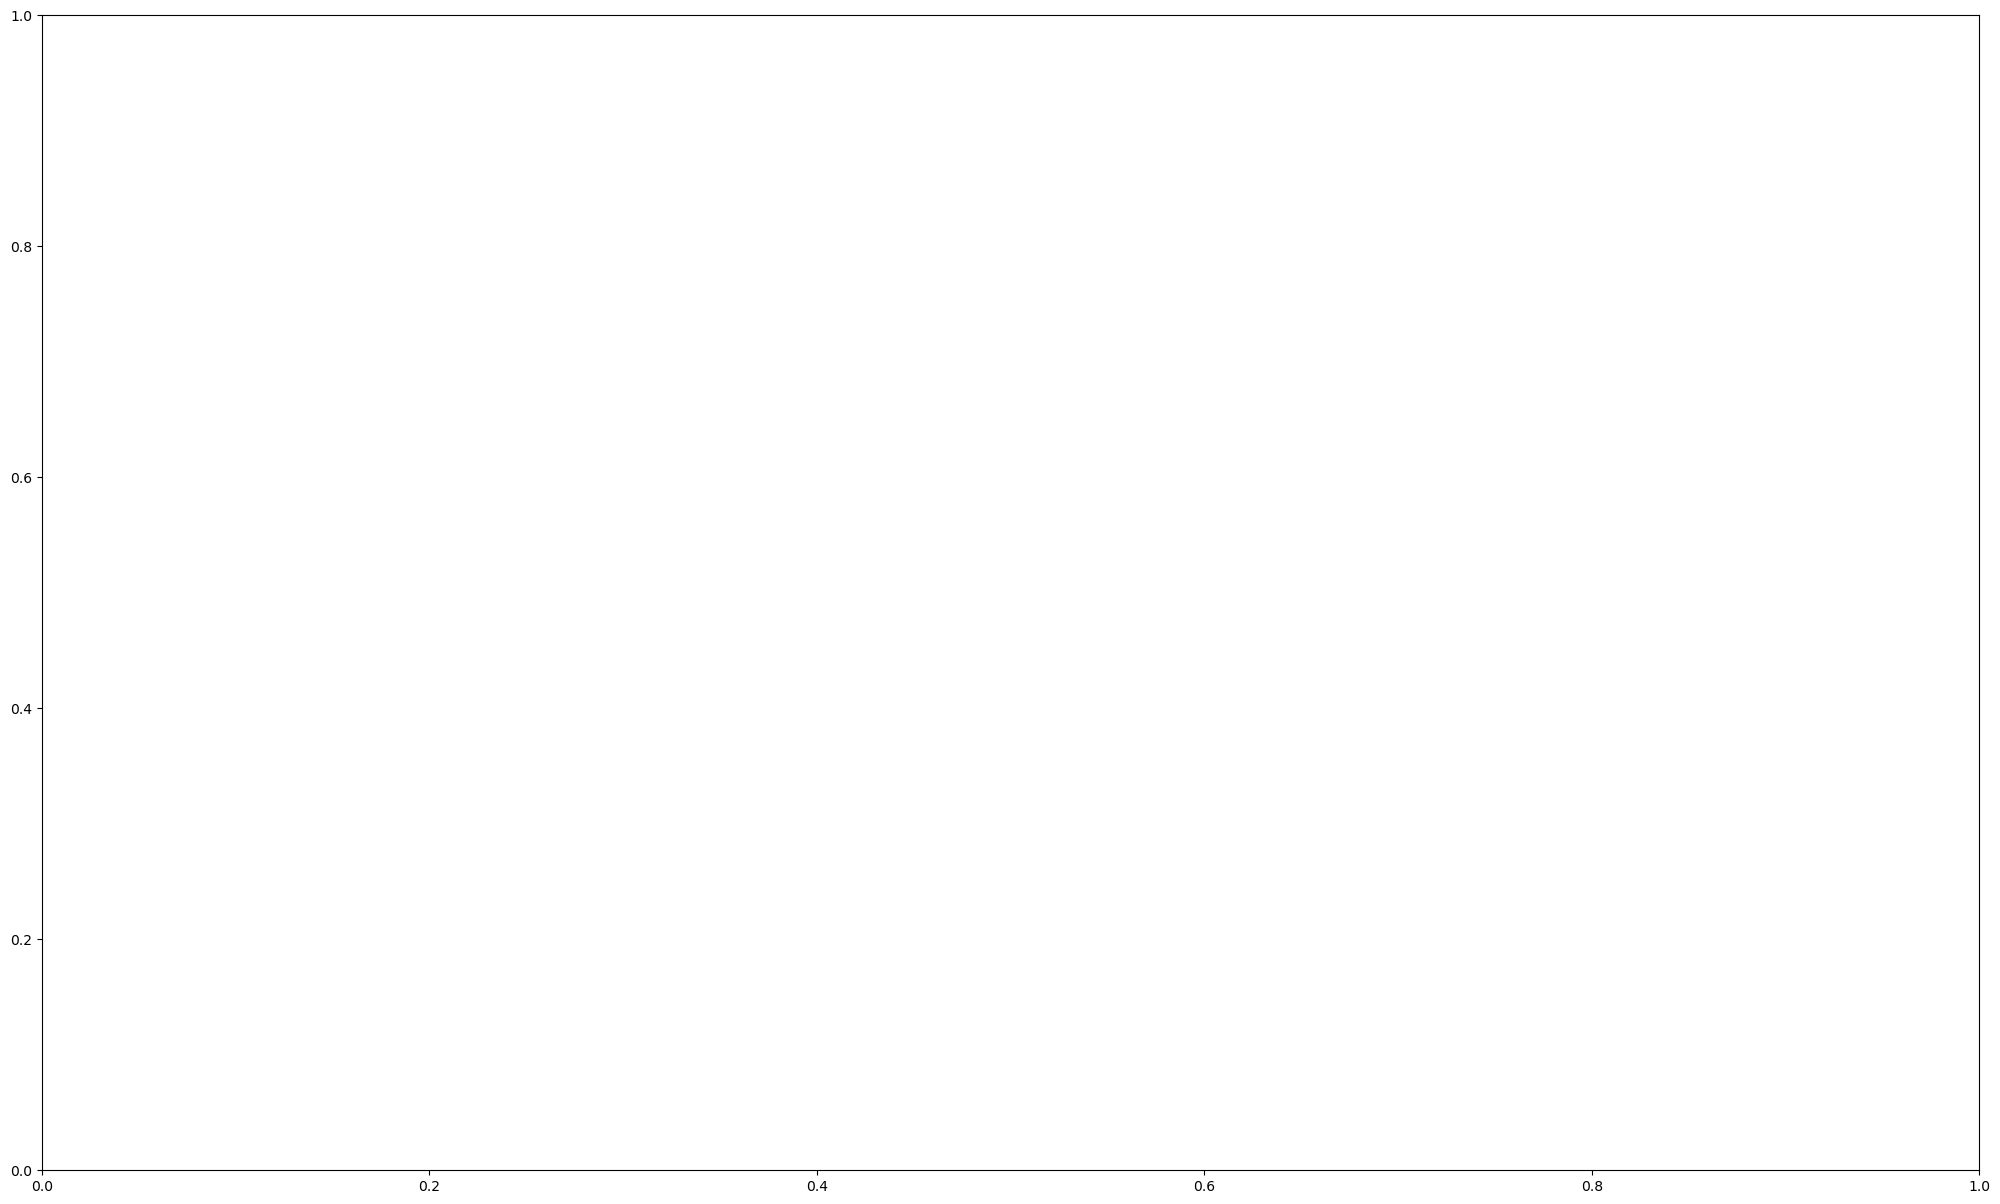

In [22]:
#We plot it (in pixels and wavelength)
vmin, vmax = np.percentile(data, [5, 99])
for iplot in range(2):
    fig, ax = plt.subplots(figsize=(25, 15))
    if iplot == 0:
        tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax, title=input_filename, cmap='gray',
                   crpix1=crpix1, crval1=crval1, cdelt1=cdelt1, cunit1=cunit1)
    else:
        tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax, title=input_filename, cmap='gray', aspect='auto')
    plt.tight_layout()

    plt.show()

# WARNING! Manual step!
Here you need to select to empty background gregions from the 2D image. They need to be at each side of the main object trace. They should not contain other traces.

In [ ]:
# Define good sky regions (iterate with next window)
skyregion1 = (300, 450)
skyregion2 = (620,650)

indices_sky = np.r_[skyregion1[0]:(skyregion1[1]+1), 
                    skyregion2[0]:(skyregion2[1]+1)]

In [ ]:
#We fit the sky level
fig, ax = plt.subplots(figsize=(10, 5))
xp = np.arange(naxis2)
yp = np.mean(data[:, 300:1001], axis=1)
ax.plot(xp, yp, label='mean spatial profile')
ax.set_xlabel('Y axis (array index)')
ax.set_ylabel('Number of counts')
ax.set_title(input_filename)

# fit of the sky level
xfit = indices_sky
yfit = yp[indices_sky]
poly_funct, yres, reject = polfit_residuals_with_sigma_rejection(
    x=xfit,
    y=yfit,
    deg=1,# you can change the order of the fit
    times_sigma_reject=3
)
xpredict = np.arange(naxis2)
ypredict = poly_funct(xpredict)
ax.plot(xpredict, ypredict, color='C2', ls='-', label='fitted sky level')
ax.plot(xfit[reject], yfit[reject], 'rx', label='rejected points')
ax.legend()

# display sky regions
ymin, ymax = ax.get_ylim()
for r in [skyregion1, skyregion2]:
    ax.axvline(r[0], lw=1, color='C1')
    ax.axvline(r[1], lw=1, color='C1')
    rect = patches.Rectangle((r[0], ymin), r[1]-r[0], ymax-ymin, facecolor='C1', alpha=0.2)
    ax.add_patch(rect)

In [ ]:
data_sky = data[indices_sky]
# initialize 2D full frame sky image
data_sky_fullframe = np.zeros((naxis2, naxis1))

# fit each image column
xfit = indices_sky
xpredict = np.arange(naxis2)

for i in tqdm(range(naxis1)):
    yfit = data_sky[:, i]
    poly_funct, yres, reject = polfit_residuals_with_sigma_rejection(
        x=xfit,
        y=yfit,
        deg=1,
        times_sigma_reject=3
    )
    data_sky_fullframe[:, i] = poly_funct(xpredict)
    
for data_, title in zip([data, data_sky_fullframe],
                       ['data', 'data_sky_fullframe']):
    fig, ax = plt.subplots(figsize=(15, 5))
    tea_imshow(fig, ax, data_, vmin=vmin, vmax=vmax, title=title, cmap='gray',
               crpix1=crpix1, crval1=crval1, cdelt1=cdelt1, cunit1=cunit1)
    plt.tight_layout()
    plt.show()

In [ ]:
data_sky_subtracted = data - data_sky_fullframe

vmin, vmax = np.percentile(data_sky_subtracted, [5, 98])

for iplot in range(2):
    fig, ax = plt.subplots(figsize=(15, 5))
    tea_imshow(fig, ax, data_sky_subtracted, vmin=vmin, vmax=vmax, title=title, cmap='gray',
               crpix1=crpix1, crval1=crval1, cdelt1=cdelt1, cunit1=cunit1)
    if iplot == 1:
        ax.set_ylim(500, 570)
    plt.tight_layout()
    plt.show()

In [ ]:
hdu = fits.PrimaryHDU(data=data_sky_subtracted, header=header)
# hdu.writeto(directory / 'swfz_caf-20240131-18:24:40-sci-blan.fits', overwrite=True)
# hdu.writeto(directory / 'swfz_caf-20240131-22:38:49-sci-blan.fits', overwrite=True)
# hdu.writeto(directory / 'swfz_caf-20240131-22:54:50-sci-blan.fits', overwrite=True)
hdu.writeto(directory /  'swfz_caf-20240131-23_10_51-sci-blan.fits', overwrite=True)

# Aligning the spectra 

# WARNING! Manual step!
Her you need to chenge 'input_filename' to each of the fits files that contain the main target of the standard calibration star.

In [ ]:
# input_filename = 'swfz_caf-20240131-18:24:40-sci-blan.fits'
# input_filename = 'swfz_caf-20240131-22:38:49-sci-blan.fits'
# input_filename = 'swfz_caf-20240131-22:54:50-sci-blan.fits'
input_filename = 'swfz_caf-20240131-23_10_51-sci-blan.fits'

data = fits.getdata(directory / input_filename)
header = fits.getheader(directory / input_filename)

In [ ]:
cunit1 = 1 * u.Unit(header['cunit1'])
crpix1 = header['crpix1'] * u.pixel
crval1 = header['crval1'] * u.Unit(cunit1)
cdelt1 = header['cdelt1'] * u.Unit(cunit1) / u.pixel
ctype1 = header['ctype1']
print(f'crpix1: {crpix1}')
print(f'crval1: {crval1}')
print(f'cdelt1: {cdelt1}')
print(f'cunit1: {cunit1}')
print(f'ctype1: {ctype1}')

In [ ]:
vmin, vmax = np.percentile(data, [5, 99])

for iplot in range(2):
    fig, ax = plt.subplots(figsize=(15, 5))
    tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax, title=input_filename,
               cmap='gray', aspect='auto')
    if iplot == 1:
        ax.set_ylim(500,575)
        ax.set_xlim(20, 1600)
    plt.tight_layout()
    plt.show()

In [ ]:
data_straight = fit_sdistortion(
    data=data,
    ns_min=520,
    ns_max=535,
    nc_min=150,
    nc_max=1400,
    median_size=(1, 51)
)

In [ ]:
hdu = fits.PrimaryHDU(data=data_straight, header=header)
hdu.writeto(f'{directory}/d{input_filename}', overwrite=True)

# Extraction of the spectra

# WARNING! Manual step!
Her you need to chenge 'input_filename' to each of the fits files that contain the main target of the standard calibration star.

In [ ]:
# input_filename = 'dswfz_caf-20240131-18:24:40-sci-blan.fits'
# input_filename = 'dswfz_caf-20240131-22:38:49-sci-blan.fits'
# input_filename = 'dswfz_caf-20240131-22:54:50-sci-blan.fits'
input_filename = 'dswfz_caf-20240131-23_10_51-sci-blan.fits'

data = fits.getdata(directory / input_filename)
header = fits.getheader(directory / input_filename)

In [ ]:
cunit1 = 1 * u.Unit(header['cunit1'])
crpix1 = header['crpix1'] * u.pixel
crval1 = header['crval1'] * u.Unit(cunit1)
cdelt1 = header['cdelt1'] * u.Unit(cunit1) / u.pixel
ctype1 = header['ctype1']
print(f'crpix1: {crpix1}')
print(f'crval1: {crval1}')
print(f'cdelt1: {cdelt1}')
print(f'cunit1: {cunit1}')
print(f'ctype1: {ctype1}')

In [ ]:
vmin, vmax = np.percentile(data, [5, 99])

for iplot in range(2):
    fig, ax = plt.subplots(figsize=(15, 5))
    tea_imshow(fig, ax, data, vmin=vmin, vmax=vmax, title=input_filename,
               cmap='gray', aspect='auto')
    if iplot == 1:
        ax.set_ylim(500, 550)
        ax.set_xlim(50, 1400)
    plt.tight_layout()
    plt.show()

In [ ]:
ns1 = 510
ns2 = 540

spectrum = np.sum(data[ns1:(ns2+1), :], axis=0)

wavelength = crval1 + ((np.arange(naxis1) + 1)*u.pixel - crpix1) * cdelt1

In [ ]:
wavelength.to(u.Angstrom)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wavelength.to(u.Angstrom), spectrum)
#ax.set_xlim(4000, 10000)
# ax.set_ylim(0, 1500)
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (number of counts)')
plt.title (input_filename)

In [ ]:
hdu = fits.PrimaryHDU(data=spectrum[np.newaxis, :], header=header)
hdu.writeto(f'{directory}/spectra1D_{input_filename}',
            overwrite=True)